In [113]:
from SymPT import *
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.linalg as la


#plt.style.use("classic")
cmap = plt.get_cmap('inferno')
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', weight = 'normal')
plt.rc('font', size = 18)
color_list = [cmap(i) for i in np.linspace(0, 1, 16)]
fntsize = 20
dir_images = "graphs/"

In [114]:
def substitution_rules(I, J, omegas, lambdas, Lambda):
    """Returns 2 dictionaries containing substitution rules for H"""
    omega_values = np.sort([np.random.uniform(-10, 10) for _ in range(I)])  
    substitution_dict = {omegas[i]: omega_values[i] for i in range(I)}
    substitution_omegas = {omegas[i]: omega_values[i] for i in range(I)}

    lambda_index = 0
    for i in range(I):
        for j in range(i+1, J):  # Iterate only over the upper triangular part
            bound = Lambda**(lambdas[lambda_index].order) * abs(omega_values[i] - omega_values[j])            
            lambda_value = bound             
            substitution_dict[lambdas[lambda_index]] = lambda_value 
            lambda_index += 1
            
    return substitution_dict, substitution_omegas


def create_Hamiltonian(I, J, mask):
    #lambdas = [RDSymbol(f"\\lambda_{i}", order = 1, real = True) for i in range(int((I**2 -I))//2)]
    omegas = [RDSymbol(f"\\omega_{i}", order = 0, real = True) for i in range(I)]

    H = sp.zeros(I, J)
    lambdas = []
    for i in range(I):
        H[i, i] = omegas[i]  # Diagonal elements
        for j in range(i + 1, J):
            lambdas.append(RDSymbol(f"\\lambda_{i}_{j}", order = 1 + mask[i, j], real = True))
            H[i, j] = lambdas[-1]
            H[j, i] = lambdas[-1]
            
    return H, omegas, lambdas

def exact_block_diagonalization(Hh, mask):
    # Unitary transformation
    _, X = la.eigh(Hh)
    
    X_inv = np.linalg.inv(X)
    
    B_mask = lambda x: np.logical_not(mask) * 1 * x

    T = X @ B_mask(X_inv) @ la.fractional_matrix_power(B_mask(X) @ B_mask(X_inv), -1/2)

    return la.inv(T) @ Hh @ T


def get_order_elements(E0, E1, V):
    E0_energy = np.max(E0.diagonal()) if len(E0.shape) == 2 else E0
    E1_energy = np.min(E1.diagonal()) if len(E1.shape) == 2 else E1
    return np.abs(np.linalg.norm(V, ord=2) / (E1_energy - E0_energy))

def fidelity(A, B):
    return np.abs(A - B).max()

In [115]:
def generate_random_hamiltonian(Lambda=0.1, max_size=5, th=0.05):
    # Creating random block structure 
    b_dims = np.random.randint(5, size=5)
    while  len(b_dims[b_dims !=0]) < 2 or np.sum(b_dims) == 0 or np.sum(b_dims) > max_size:
        b_dims = np.random.randint(5, size=5)
    structure = get_structure(b_dims)
    mask = Block(structure)

    # Creating random Hamiltonian
    I, J = structure.shape
    H, omegas, lambdas = create_Hamiltonian(I, J, structure)
    values, omegas_dict = substitution_rules(I,J, omegas, lambdas, Lambda)

    Hh = np.array(H.subs(values), dtype=float)

    H_blocks = []
    V_blocks = {}
    prev_dim = 0
    b_dims = b_dims[b_dims != 0]
    for d in b_dims:
        H_blocks.append(Hh[prev_dim: prev_dim + d, prev_dim:prev_dim + d])
        prev_dim += d

    prev_d1 = 0
    prev_d1_d2 = 0
    for i, d1 in enumerate(b_dims):
        prev_d1_d2 = prev_d1 + d1
        for j, d2 in enumerate(b_dims[i + 1:]):
            j += i + 1
            V_blocks[i, j] = Hh[prev_d1:prev_d1 + d1, prev_d1_d2:prev_d1_d2 + d2]
            prev_d1_d2 += d2
        prev_d1 += d1

    values_orders = []
    for i, block_i in enumerate(H_blocks):
        for j, block_j in enumerate(H_blocks[i+1:]):
            j += i + 1
            value_order = get_order_elements(block_i, block_j, V_blocks[i, j])
            values_orders.append(value_order)

    random_hamiltonian = {
        'Hh': Hh,
        'H': H,
        'mask': mask,
        'structure': structure,
        'H_blocks': H_blocks,
        'V_blocks': V_blocks,
        'values': values,
        'values_orders': values_orders,
        'value_bounded': np.max(values_orders),
        'is_bounded': np.max(values_orders) < th
    }
    
    return random_hamiltonian

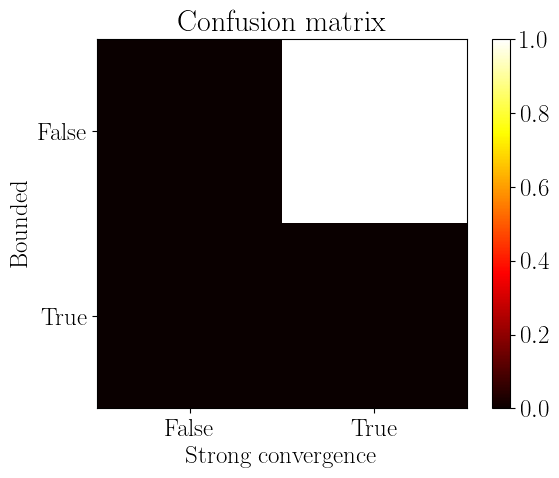

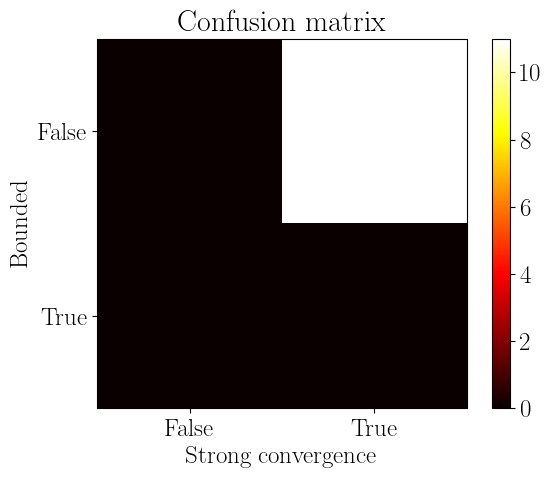

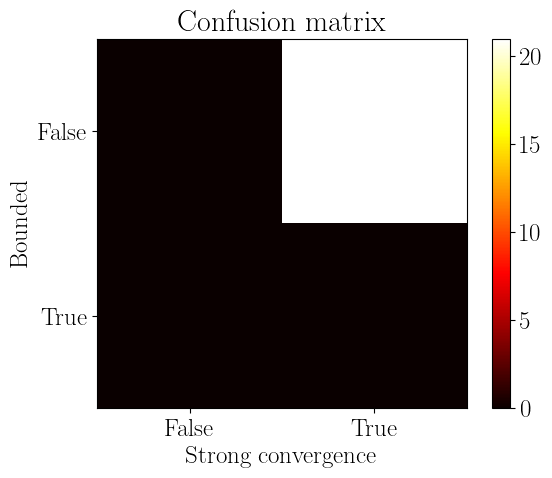

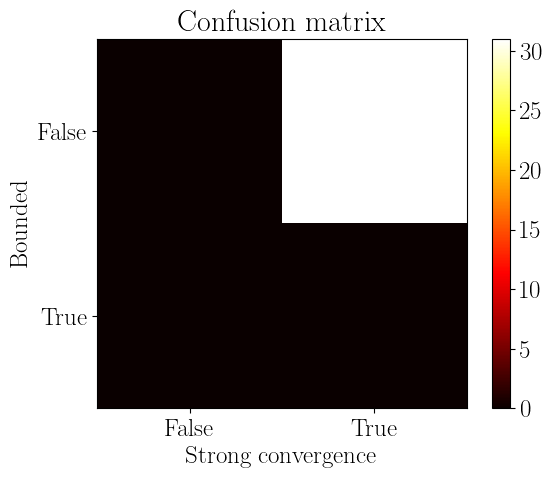

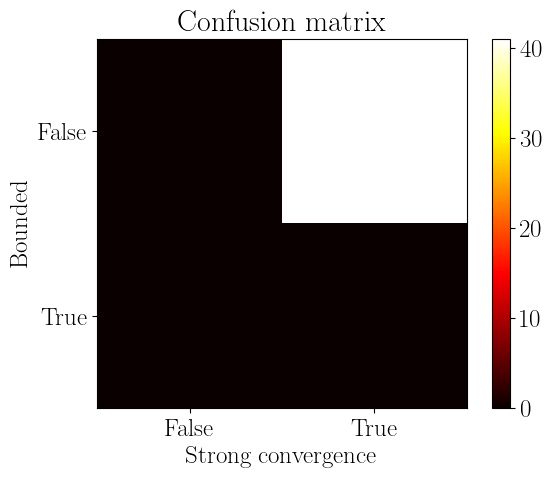

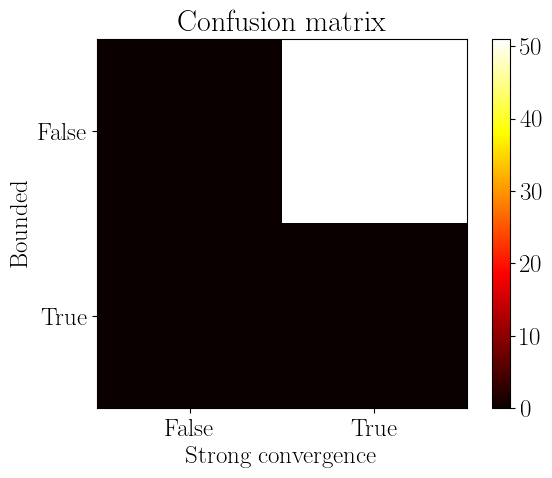

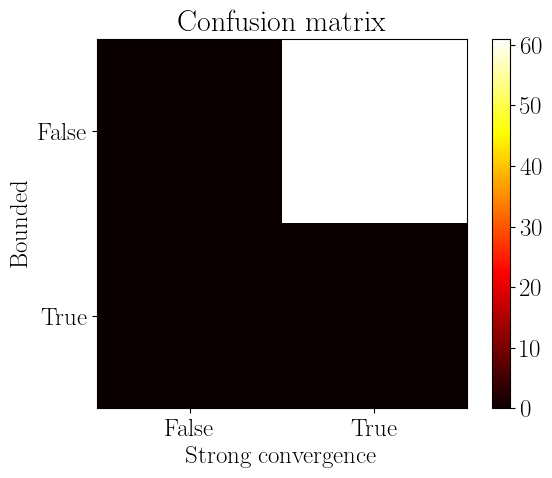

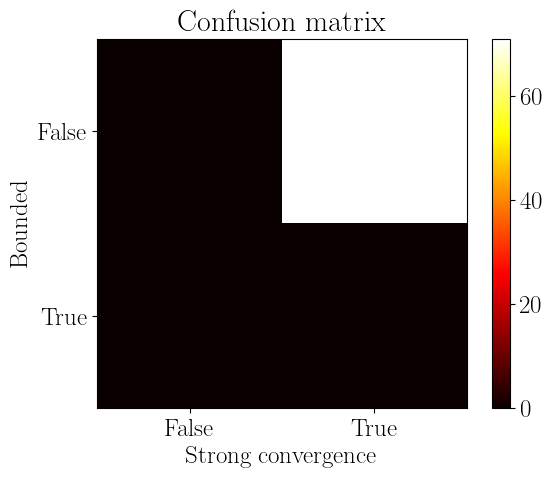

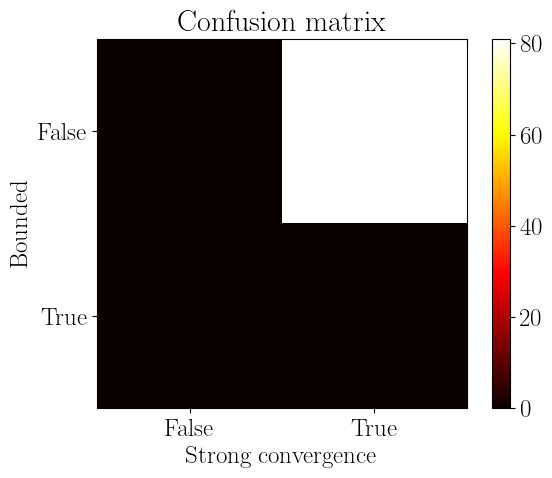

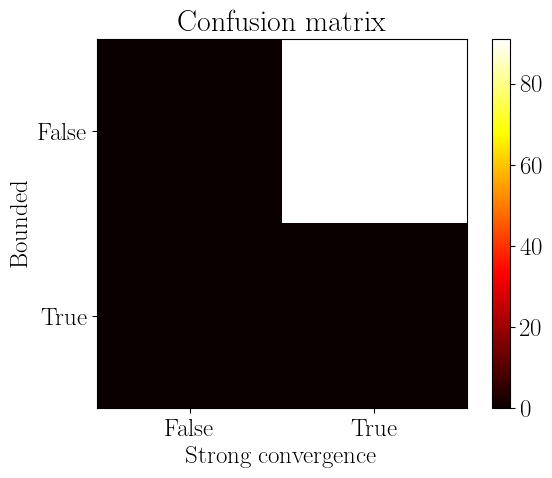

In [116]:
results = {(True, True):[], (True, False):[], (False, True):[], (False, False):[]} # (is_bounded, strong_convergence)
max_tries = 100
max_order = 5
Lambda = 0.1
th = Lambda**2 / 2

for i in range(max_tries):
    random_hamiltonian = generate_random_hamiltonian(Lambda=Lambda, th=th)

    Hh = random_hamiltonian['Hh']
    H = random_hamiltonian['H']
    mask = random_hamiltonian['mask']
    structure = random_hamiltonian['structure']
    values = random_hamiltonian['values']
    is_bounded = random_hamiltonian['is_bounded']
    value_bounded = random_hamiltonian['value_bounded']


    exact_result = exact_block_diagonalization(Hh, structure)
    Eff_Frame = EffectiveFrame(H, symbol_values=values, verbose=False)
    Eff_Frame.solve(max_order=max_order, method='LA', mask=mask)
    LA_res = Eff_Frame.get_H(return_form='matrix')

    LA_corrections = Eff_Frame.corrections # extracting order corrections from effective frame
    error_order = [] # will store solutions to each order
    LA_res = np.zeros_like(exact_result) # initializing result
    LA_res_order = []
    for order in range(max_order + 1): 
        LA_res += np.array(LA_corrections.get(order, sp.zeros(*exact_result.shape)).evalf(), dtype=float) # correcting result with current order
        LA_res_order.append(LA_res.copy())
        error_order.append(fidelity(exact_result, LA_res)) # append fidelity of current order

    error_order = np.array(error_order)
    error_order[error_order <= np.finfo(float).eps] = np.finfo(float).eps
    error_order_diff = np.diff(error_order)
    error_min = np.array([np.min([error1, error2]) for error1, error2 in zip(error_order[1:], error_order[:-1])])
    error_min = error_min[error_order_diff > 0]
    error_order_diff = error_order_diff[error_order_diff > 0]

    res = {'Hh' : Hh,
           'exact_result' : exact_result,
           'corrections' : LA_corrections,
    }
    
    results[(is_bounded, np.all(error_order_diff < error_min) )].append([value_bounded, error_order])

    if i % 10 == 0:
        confusion_matrix = np_zeros((2, 2))
        for key, value in results.items():
            key = (int(key[0]), int(key[1]))
            confusion_matrix[key] = len(value)
        fig, ax = plt.subplots()
        im = ax.imshow(confusion_matrix, cmap='hot', interpolation='nearest')
        fig.colorbar(im)
        ax.set_xticks(np.arange(2))
        ax.set_yticks(np.arange(2))
        ax.set_xticklabels(['False', 'True'])
        ax.set_yticklabels(['False', 'True'])
        ax.set_xlabel('Strong convergence')
        ax.set_ylabel('Bounded')
        plt.title('Confusion matrix')
        plt.show()
        


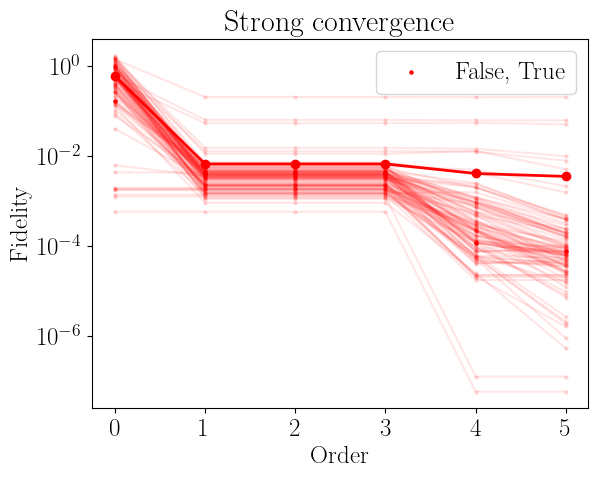

In [119]:
fig, ax = plt.subplots()

colors = ['r', 'b', 'g', 'y']

for key in [(True, True), (True, False), (False, True), (False, False)]:
    if len(results[key]) == 0:
        continue

    error_mean = []
    error_std = []

    for order in range(max_order + 1):
        error_mean.append(np.mean([res[1][order] for res in results[key]]))
        error_std.append(np.std([res[1][order] for res in results[key]]))
    #    print(key, order, error_mean[-1], error_std[-1])


    #ax.errorbar(range(max_order + 1), error_mean, yerr=error_std, fmt='o', label=f'{key[0]}, {key[1]}')
    color = colors.pop(0)
    ax.scatter(range(max_order + 1), results[key][0][1], color=color, label=f'{key[0]}, {key[1]}', s=5)
    for res in results[key][1:]:
        ax.plot(range(max_order + 1), res[1], color=color, alpha=0.1)
        ax.scatter(range(max_order + 1), res[1], color=color, s=5, alpha=0.1)

    ax.plot(range(max_order + 1), error_mean, '-o', color=color, lw=2)
    #ax.fill_between(range(max_order + 1), np.array(error_mean) - np.array(error_std), np.array(error_mean) + np.array(error_std), alpha=0.2, color=color)
    ax.set_xlabel('Order')
    ax.set_ylabel('Fidelity')

    ax.set_title('Strong convergence')
    ax.set_yscale('log')
    #ax.set_ylim([1e-7, 2])

plt.legend()